In [63]:
from time import time
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [64]:
#define the states of the inverted pendulum
theta = ca.SX.sym('theta')
theta_dot = ca.SX.sym('theta_dot')
x = ca.vertcat(theta, theta_dot)

#define the control input
u=ca.SX.sym('u')

# define the pendulum system equations
ode = ca.vertcat(theta_dot, -3*ca.sin(theta) - theta_dot+u)

# ODE right hand side function
f = ca.Function('f', [x, u], [ode], ['x', 'u'], ['ode'])

T= 1
N= 50
sim_time = 10
step_horizon = T/N

# this integration options will integrate for 0.1 seconds
intg_options = {"tf": T/N, 'simplify': True, 'number_of_finite_elements': 4}

#check if f is working by giving f(x, u) and t = 0
# print(f(ca.vertcat(0.2, 0.3), 0.4))
dae = {'x': x, 'ode': ode, 'p': u}
# here p is parameters or stuffs that don't change during integration
#this intg object is a discretized version of the ode
intg = ca.integrator('intg', 'rk', dae, intg_options)

res = intg(x0=x,p=u)
x_next = res['xf']

n_states = x.numel()
n_controls = u.numel()

In [65]:
# given (x,u) compute x_next using F API
F = ca.Function('F', [x, u], [x_next], ['x', 'u'], ['x_next'])
# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)

In [66]:
Q = ca.diag([1000, 100])
R = ca.diag([10])

g = X[:, 0] - P[:n_states]  # constraints in the equation
#compute the objective symbolically
obj = 0
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    con_prev = U[:,k-1]
    obj = obj +(st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = ca.vertcat(g, st_next - st_next_RK4)

In [67]:
def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))
    #print(next_state.shape)
    next_state = F(state_init, u[:, 0])
    #print(next_state.shape)
    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())

In [68]:
t0 = 0
state_init = ca.DM([0, 0])        # initial state
state_target = ca.DM([np.pi,0])  # target state

xx = ca.DM.zeros((n_states, int(sim_time/step_horizon)+1))
xx[:,0] = state_init
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1) # initial state full
xx1 = np.zeros((n_states, N+1, int(sim_time/step_horizon)))
u_cl = ca.DM.zeros((n_controls, int(sim_time/step_horizon)))  # closed-loop control

In [69]:
opt_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {'f': obj, 'x': opt_variables,'p': P, 'g': g}
opts = {'ipopt': {'max_iter': 2500, 'print_level': 0, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6}, 'print_time': False}


mpc_iter = 0
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # theta lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # theta_dot lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # theta upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # theta_dot upper bound

lbx[n_states*(N+1):] = -10                 # u input lower bound
ubx[n_states*(N+1):] = 10                  # u input upper bound

args = {
    'lbg': ca.DM.zeros((n_states*(N+1))),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1))),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

print(args['lbg'].shape)
print(g.shape)

(102, 1)
(102, 1)


In [70]:
main_loop = time()  # return time in sec
times = np.array([[0]])
while (ca.norm_2(state_init - state_target) > 1e-3) and (mpc_iter * step_horizon < sim_time): # 0.1*200
    t1 = time()
    args['p'] = ca.vertcat(
        state_init,    # current state
        state_target   # target state
    )
    # optimization variable current state
    args['x0'] = ca.vertcat(ca.reshape(X0.T,n_states*(N+1),1),ca.reshape(u0.T, n_controls*(N), 1)) #adding initial state and input constrains for shifted horizon
    sol = solver(x0=args['x0'], lbx=args['lbx'], ubx=args['ubx'], lbg=args['lbg'], ubg=args['ubg'], p=args['p'])

    u = ca.reshape(sol['x'][n_states*(N+1):].T, n_controls, N) #only extract the control inputs from the solution

    u_cl = ca.horzcat(u_cl[:,1:], u[:,0])
    #append the last time step
    t = np.vstack((t,t0))

    t0, state_init, u0 = shift_timestep(T, t0, state_init, u, f)

    xx[:,mpc_iter] = state_init.T

    mpc_iter = mpc_iter + 1
    t2 = time()
    print("mpc iteration", mpc_iter)
    # print(t2-t1)
    times = np.vstack((times,t2-t1))

main_loop_time = time()
ss_error = ca.norm_2(state_init - state_target)
print('\n\n')
print('Total time: ', main_loop_time - main_loop)
print('total mpc iteration: ', mpc_iter)
print('mpc running time: ', mpc_iter * step_horizon)
print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
print('final error: ', ss_error)

mpc iteration 1
mpc iteration 2
mpc iteration 3
mpc iteration 4
mpc iteration 5
mpc iteration 6
mpc iteration 7
mpc iteration 8
mpc iteration 9
mpc iteration 10


mpc iteration 11
mpc iteration 12
mpc iteration 13
mpc iteration 14
mpc iteration 15
mpc iteration 16
mpc iteration 17
mpc iteration 18
mpc iteration 19
mpc iteration 20
mpc iteration 21
mpc iteration 22
mpc iteration 23
mpc iteration 24
mpc iteration 25
mpc iteration 26
mpc iteration 27
mpc iteration 28
mpc iteration 29
mpc iteration 30
mpc iteration 31
mpc iteration 32
mpc iteration 33
mpc iteration 34
mpc iteration 35
mpc iteration 36
mpc iteration 37
mpc iteration 38
mpc iteration 39
mpc iteration 40
mpc iteration 41
mpc iteration 42
mpc iteration 43
mpc iteration 44
mpc iteration 45
mpc iteration 46
mpc iteration 47
mpc iteration 48
mpc iteration 49
mpc iteration 50
mpc iteration 51
mpc iteration 52
mpc iteration 53
mpc iteration 54
mpc iteration 55
mpc iteration 56
mpc iteration 57
mpc iteration 58
mpc iteration 59
mpc iteration 60
mpc iteration 61
mpc iteration 62
mpc iteration 63
mpc iteration 64
mpc iteration 65
mpc iteration 66
mpc iteration 67
mpc iteration 68
mpc iteration 

(500, 1)


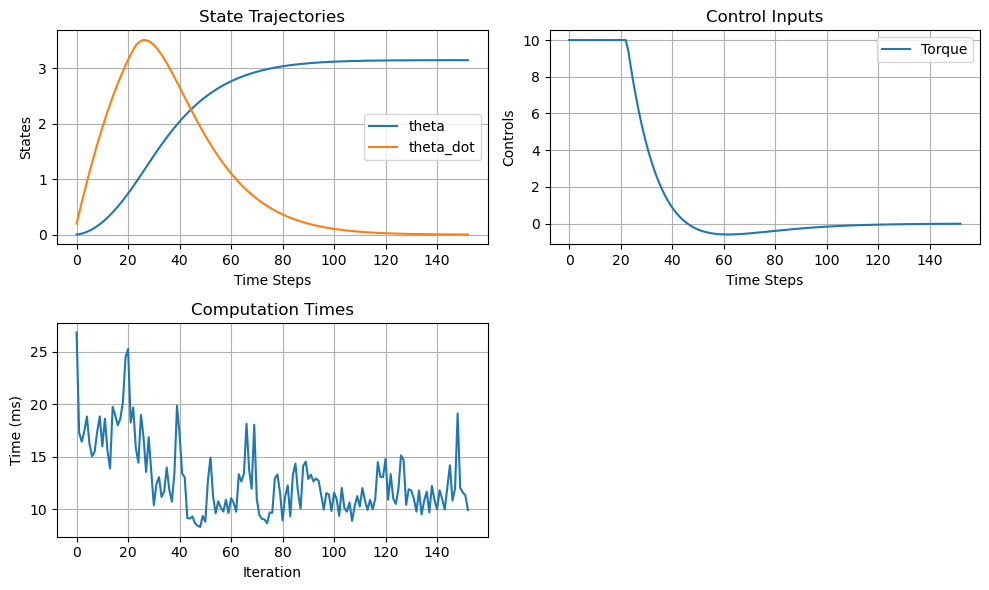

In [71]:
import matplotlib.pyplot as plt

# Plot state trajectories
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(xx.T[:mpc_iter, :])
plt.title('State Trajectories')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.grid(True)
plt.legend(['theta', 'theta_dot'])  # Added Legend

# Plot control inputs
plt.subplot(2, 2, 2)
print(u_cl.T.shape)
u_cl_np = np.array(u_cl)  # Convert to numpy array if not already
plt.plot(u_cl_np.T[-mpc_iter:, :])
plt.title('Control Inputs')
plt.xlabel('Time Steps')
plt.ylabel('Controls')
plt.grid(True)
plt.legend(['Torque'])  # Added Legend, assuming there are two controls, modify as needed

# Plot computation times
plt.subplot(2, 2, 3)
times_np = np.array(times[1:])  # Convert to numpy array and skip the first element (initialization)
plt.plot(times_np * 1000)  # Convert to milliseconds
plt.title('Computation Times')
plt.xlabel('Iteration')
plt.ylabel('Time (ms)')
plt.grid(True)
# If there is more than one line in the computation times plot, you should also add a corresponding legend here

# Display the plots
plt.tight_layout()
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Example states (angles in radians)
xx_np = np.array(xx)  # Convert to numpy array if not already
states = xx_np.T[:mpc_iter, 0]

# Create a figure and an axes
fig, ax = plt.subplots(figsize=(5,5))

# Set the limits of the plot
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Plot the pendulum rod as a line and the mass as a dot
line, = ax.plot([], [], 'o-', lw=2)

def init():
    """Initialize the line and point."""
    line.set_data([], [])
    return (line,)

def update(frame):
    """Update the line and point for each frame."""
    x = np.sin(states[frame])
    y = -np.cos(states[frame])
    line.set_data([0, x], [0, y])
    return (line,)

ani = FuncAnimation(fig, update, frames=len(states), init_func=init, blit=True)

# Display the animation
plt.close(ani._fig)
HTML(ani.to_jshtml())
